In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
import matplotlib as mpl
from tqdm import tqdm_notebook
import cdpm
from sklearn.preprocessing import add_dummy_feature
import pandas_datareader as pd_reader
import seaborn  as sns
from matplotlib import cm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3, suppress=True)

In [3]:
alpha_for_ci = .95

In [4]:
filename = '../results/daily_estimate.tmp.hdf'


In [5]:
results = cdpm.read_results(filename)
beta_draws = results['beta']
comp_cov_draws = results['comp_cov']
cluster_identity_draws = results['cluster_identity']
stick_draws = results['sticks']
trans_mat_draws = results['trans_mat']
regressor = results['regressor']
regressand = results['regressand']
data = results['data']
num_draws = len(beta_draws)

In [6]:
rename_dict = {"VNQ_vol": "VNQ Vol", "XLF_vol": "XLF Vol", "VFH_vol": "VFH Vol"}

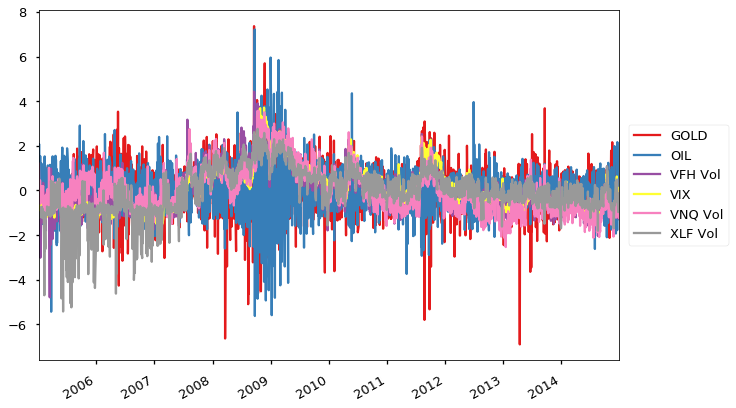

In [7]:
data_fig, data_ax = mpl.pyplot.subplots(1,1)
data.rename(columns=rename_dict).sort_index(axis=1).plot(ax=data_ax, colormap=cm.get_cmap('Set1'))
data_ax.set_xlabel("")
data_ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
data_fig.savefig('../doc/density_figures/data_hf.tmp.pdf', transparent=True, frameon=False, bbox_inches='tight',
                 pad_inches=0)

## Results

In [8]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [9]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

In [10]:
trans_mat = pd.DataFrame(np.nanmean(trans_mat_draws[:, :10, :10], axis=0))
trans_mat.dropna(axis=0, how='all').dropna(axis=1, how='all')

0         1         2         3         4         5         6  \
0  0.278621  0.170123  0.120838  0.096705  0.083373  0.075476  0.070787   
1  0.256377  0.202002  0.147149  0.085194  0.076540  0.069236  0.062646   
2  0.256937  0.146771  0.176135  0.108167  0.078412  0.069647  0.066195   
3  0.259773  0.123051  0.103345  0.157420  0.092940  0.070862  0.068751   
4  0.259319  0.117708  0.097600  0.089525  0.141324  0.079858  0.070983   
5  0.257903  0.119640  0.090235  0.084223  0.080539  0.131283  0.075356   
6  0.264518  0.116602  0.089899  0.079560  0.077940  0.075721  0.126465   
7  0.257753  0.113019  0.085303  0.081084  0.073783  0.077005  0.070499   
8  0.265928  0.112215  0.082233  0.075867  0.069817  0.070115  0.070858   
9  0.256889  0.109319  0.075615  0.068224  0.064593  0.068383  0.070211   

          7         8         9  
0  0.061827  0.051301  0.040491  
1  0.058992  0.046634  0.038106  
2  0.057318  0.048041  0.037238  
3  0.056260  0.047713  0.040658  
4  0.059373  0.049439  0.037323  
5  0.060791  0.049903  0.043239  
6  0.060909  0.048342  0.041553  
7  0.115677  0.054210  0.041954  
8  0.059367  0.102318  0.046531  
9  0.061437  0.053241  0.100984

In [11]:
stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws, progress_bar=tqdm_notebook)

In [13]:
stationary_dist.mean().head()

0    0.210315
1    0.144322
2    0.125438
3    0.099990
4    0.084488
dtype: float64

In [14]:
np.mean(comp_cov_draws[:,1])

0.07998064532557057

In [15]:
np.mean(comp_cov_draws[:,0])

0.08873600647393565

In [16]:
beta_draws.shape

(5000, 19, 6, 6)

## Parameter Estimates

In [17]:
comp_cov_draws.shape

(5000, 19, 6, 6)

In [18]:
posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in np.unique(cluster_identity_draws)]), index=regressand.index)

In [19]:
vols = []
for idx, name in enumerate(regressand.columns):
    vols.append(pd.DataFrame(np.sum([prop * np.nanmean(comp_cov_draws[:,n, idx, idx], axis=0)
                                    for n, prop in posterior_cluster_probs.iteritems()], axis=0),
                             columns=[name], index=regressand.index))
    
innov_vol_data = pd.concat(vols, axis=1)

In [20]:
innov_vol_data.mean().apply(np.sqrt)

GOLD       1.008114
OIL        0.955137
VFH_vol    0.546021
VIX        0.182755
VNQ_vol    0.346158
XLF_vol    0.341683
dtype: float64

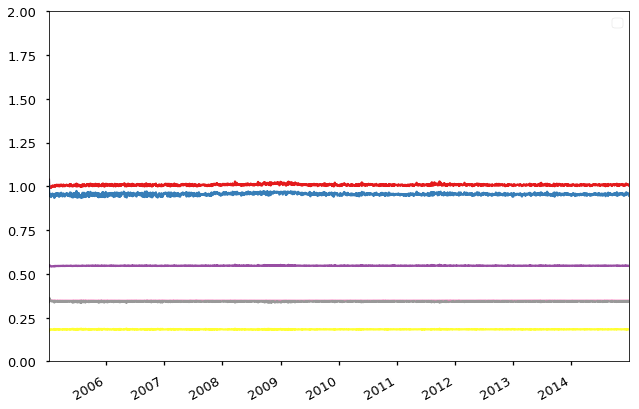

In [21]:
innov_vol_fig, innov_vol_ax = mpl.pyplot.subplots()
innov_vol_data.apply(np.sqrt).plot(ax=innov_vol_ax, colormap=cm.get_cmap('Set1'))
innov_vol_ax.set_ylim([0,2])
innov_vol_ax.legend([])
innov_vol_fig.savefig('../doc/density_figures/innov_vol_hf.tmp.pdf', transparent=True, frameon=False,
                      bbox_inches='tight', pad_inches=0)

In [22]:
vols = []
for idx, name in tqdm_notebook(enumerate(regressand.columns), total=regressand.shape[1]):
    inner_it = tqdm_notebook(posterior_cluster_probs.iteritems(), total=posterior_cluster_probs.shape[1], 
                            leave=False)
    vols.append(pd.DataFrame(np.sum([prop * np.nanvar(regressor @ np.atleast_2d(beta_draws[:,n,:, idx].T), axis=1)
                                     for n, prop in inner_it], axis=0),columns=[name], index=regressand.index))
    
vols_from_beta = pd.concat(vols, axis=1)

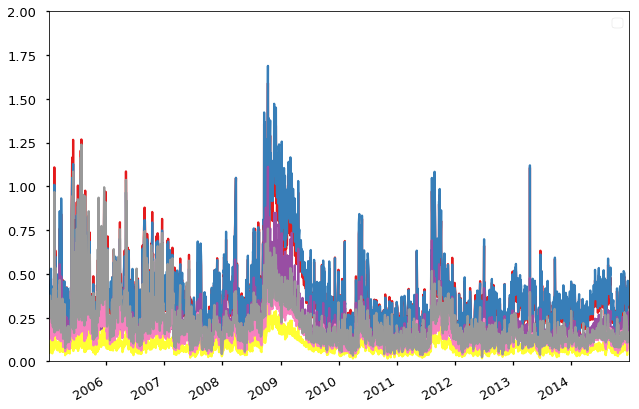

In [23]:
beta_vol_fig, beta_vol_ax = mpl.pyplot.subplots()
vols_from_beta.apply(np.sqrt).plot(ax=beta_vol_ax, colormap=cm.get_cmap('Set1'))
beta_vol_ax.set_ylim([0,2])
beta_vol_ax.legend([])
beta_vol_fig.savefig('../doc/density_figures/beta_vol_hf.tmp.pdf', transparent=True, frameon=False, bbox_inches='tight',
                      pad_inches=0)

In [24]:
means = []
for idx, name in enumerate(regressand.columns):
    means.append(pd.DataFrame(np.sum([prop * regressor.values.dot(np.nanmean(beta_draws[:,n, :,idx], axis=0).T)
                                    for n, prop in posterior_cluster_probs.iteritems()], axis=0),
                             columns=[name], index=regressand.index))
    
means_data = pd.concat(means, axis=1)

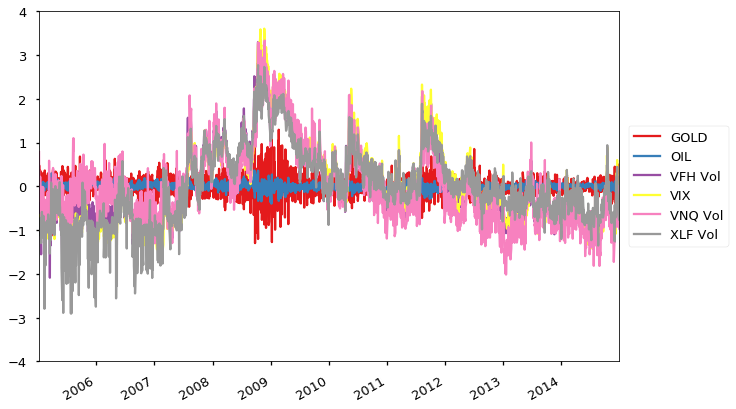

In [25]:
means_fig, means_ax = mpl.pyplot.subplots()
means_data.rename(columns=rename_dict).sort_index(axis=1).plot(ax=means_ax, colormap=cm.get_cmap('Set1'))
means_ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
means_ax.set_ylim([-4,4])
means_fig.savefig('../doc/density_figures/means_data_hf.tmp.pdf', transparent=True, frameon=False, bbox_inches='tight',
                      pad_inches=0)

## Forecasting

In [26]:
forecast = cdpm.forecast_draws(cluster_identity_draws, trans_mat_draws,
                                           beta_draws,comp_cov_draws,regressor, progress_bar=tqdm_notebook)

/home/sangrey/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


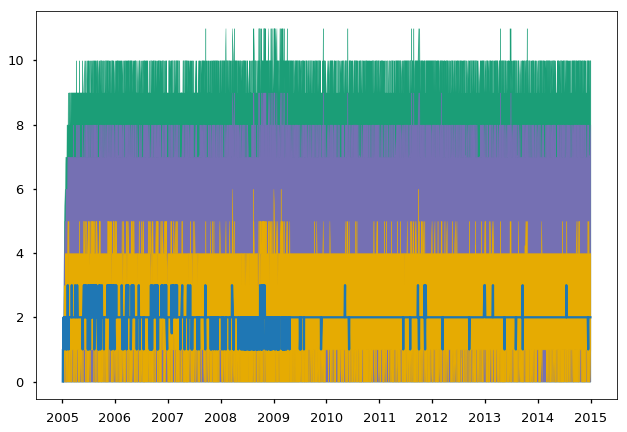

In [27]:
cluster_id_fig, cluster_id_ax = mpl.pyplot.subplots(1,1)
cdpm.fan_plot(ax=cluster_id_ax, data=pd.DataFrame(cluster_identity_draws.T, index=regressor.index), 
              percentiles=percentiles, cm=cm.get_cmap('Dark2'))

In [28]:
posterior_cluster_probs.iloc[:,:5].head()

0       1       2       3       4
2005-01-06  1.0000  0.0000  0.0000  0.0000  0.0000
2005-01-07  0.4148  0.5852  0.0000  0.0000  0.0000
2005-01-10  0.3176  0.3766  0.3058  0.0000  0.0000
2005-01-11  0.3160  0.2480  0.3000  0.1360  0.0000
2005-01-12  0.2682  0.2026  0.2682  0.2092  0.0518

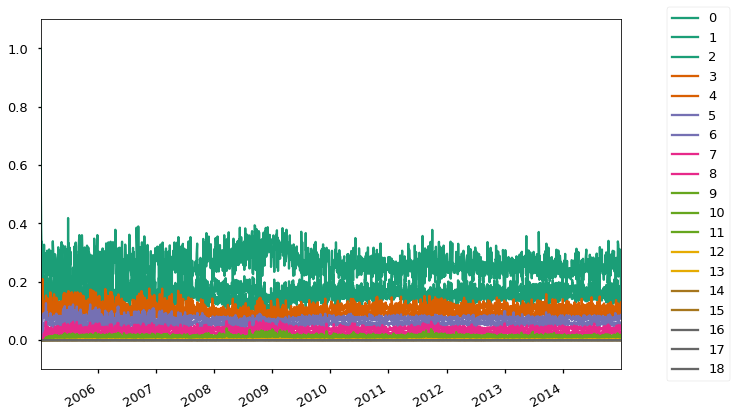

In [29]:
cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
posterior_cluster_probs.plot(ax=cluster_probs_ax, colormap=cm.get_cmap('Dark2'))
cluster_probs_ax.set_ylim([-.1,1.1])
cluster_probs_ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

cluster_probs_fig.savefig('../doc/density_figures/posterior_cluster_probs_hf.tmp.pdf', transparent=True, 
                          frameon=False, bbox_inches='tight', pad_inches=0)

In [30]:
percentiles

[1, 5, 25, 50, 75, 95, 99]

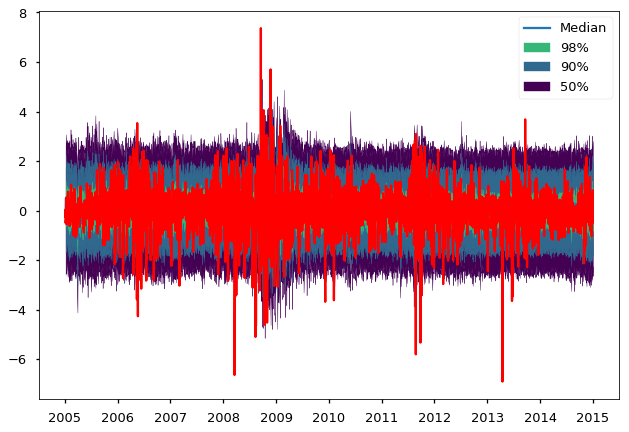

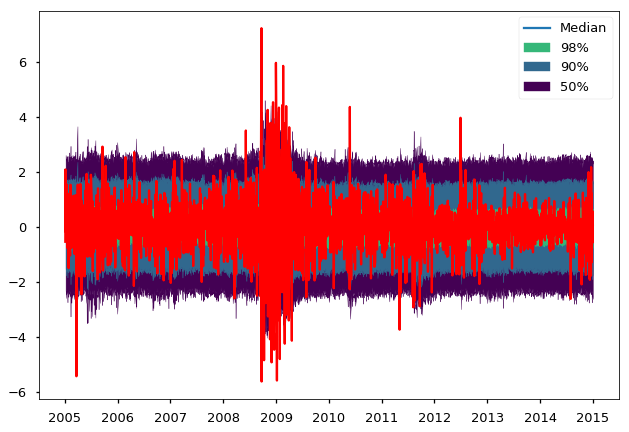

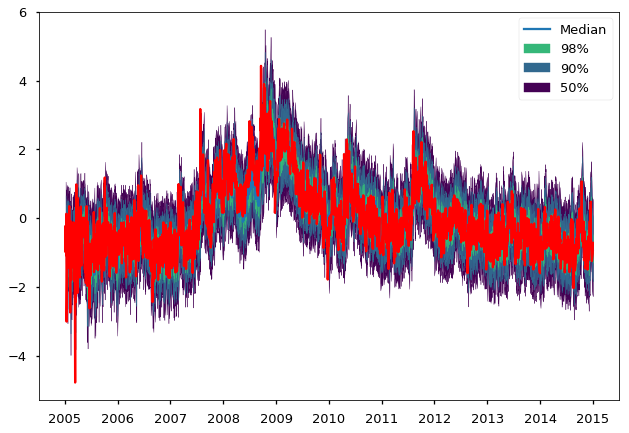

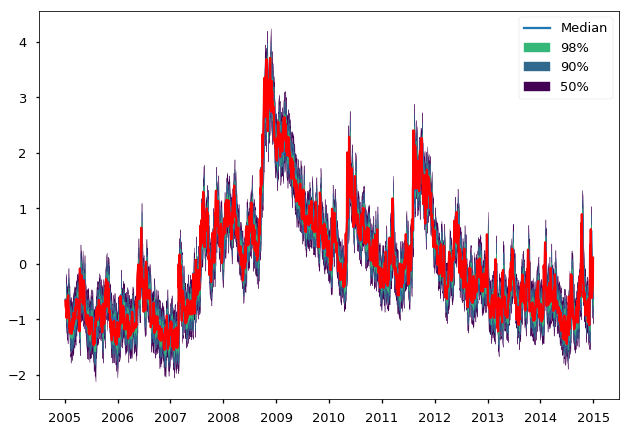

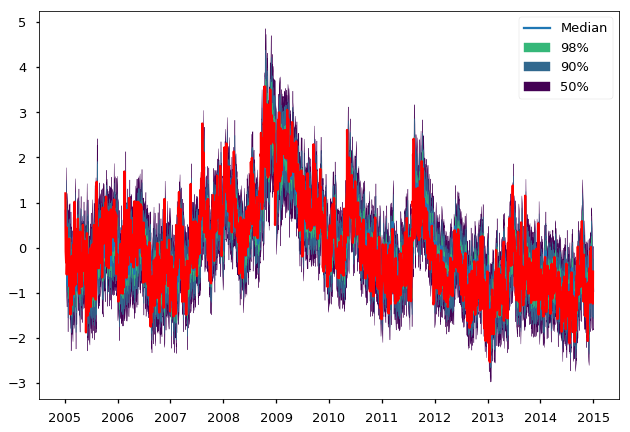

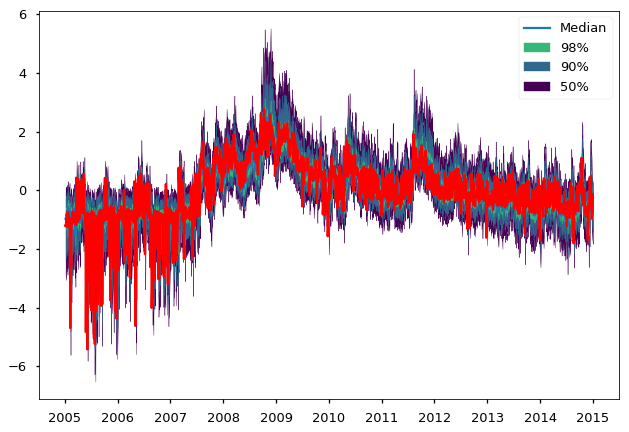

In [31]:
for idx, val in enumerate(regressand.columns):
    data_comparison_fig, data_comparison_ax = mpl.pyplot.subplots(1,1)
    cdpm.fan_plot(ax=data_comparison_ax, data=pd.DataFrame(forecast[:,idx,:], index=data.index[2:]),
              percentiles=tuple(percentiles), labels=['Median', '50%', '90%', '98%'])
    data_comparison_ax.legend()
    data_comparison_ax.plot(data.index, data[val].values, color='red', zorder=100)

    data_comparison_fig.savefig(f'../doc/density_figures/{val}_forecasts.tmp.pdf', transparent=True,frameon=False,
                               bbox_inches='tight', pad_inches=0)

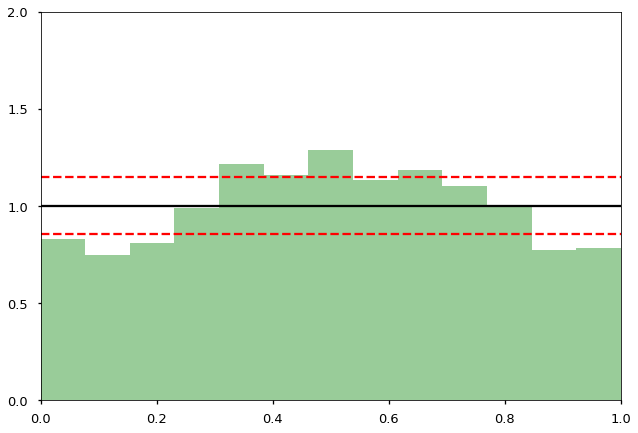

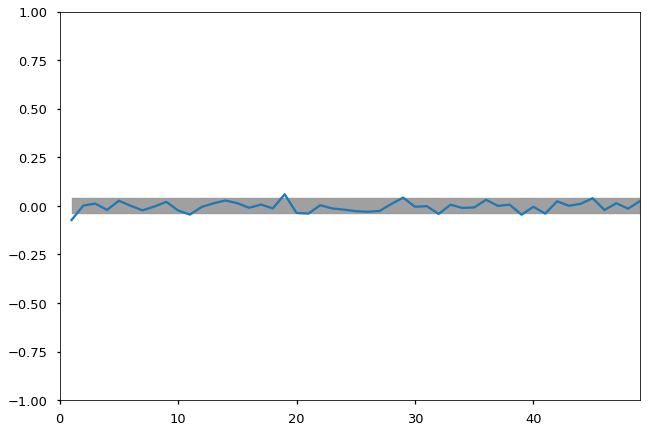

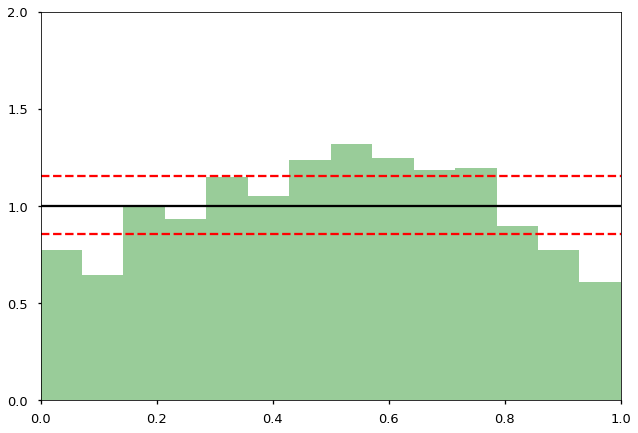

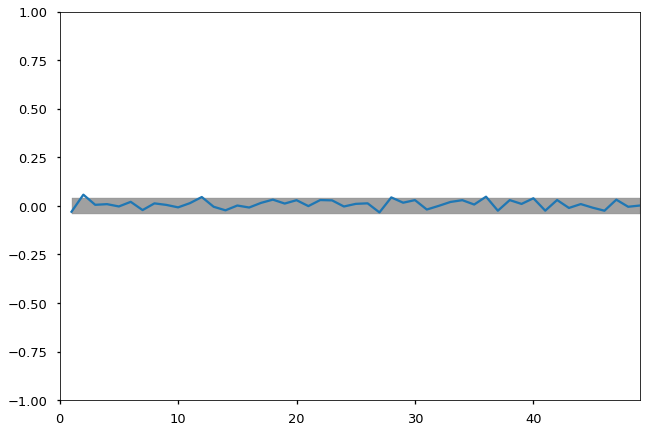

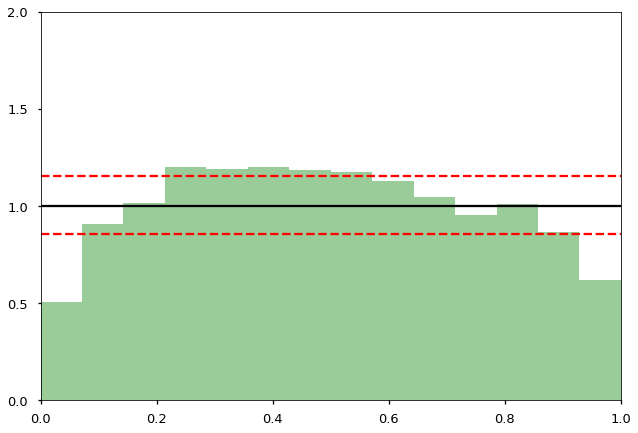

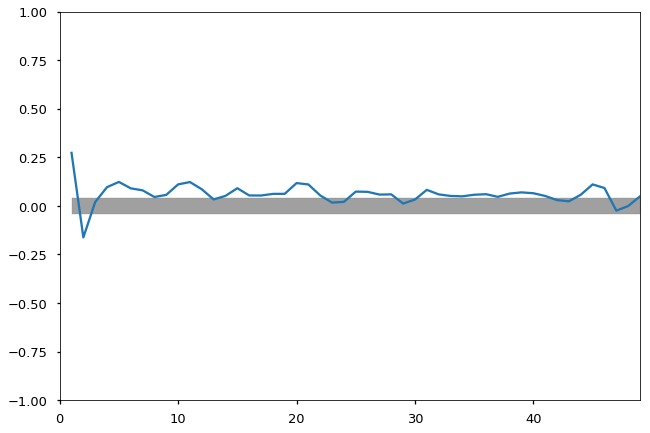

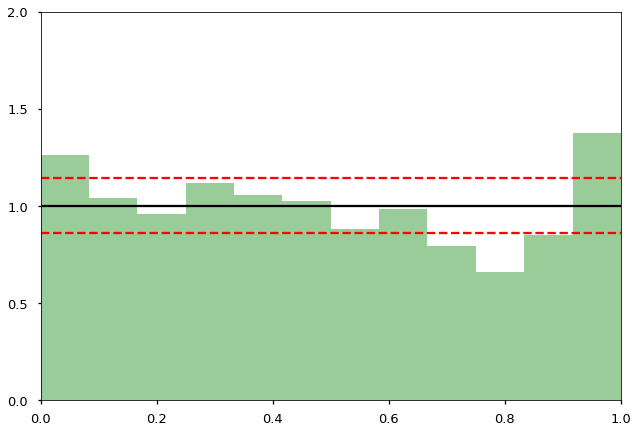

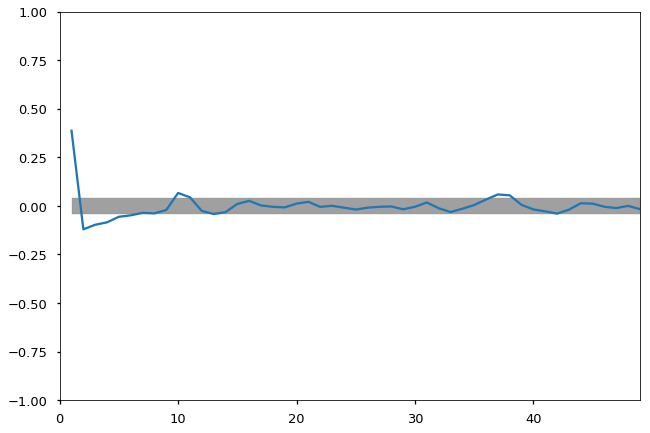

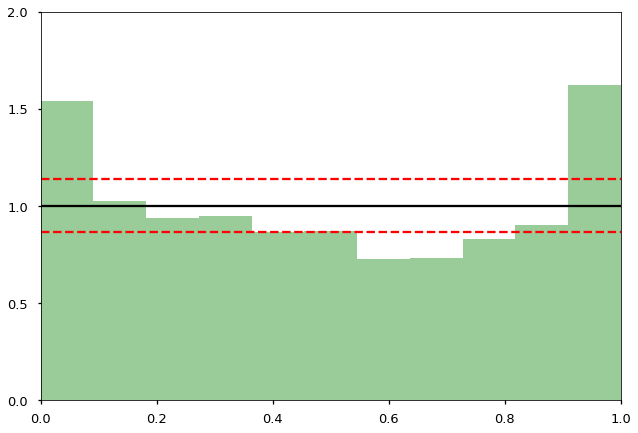

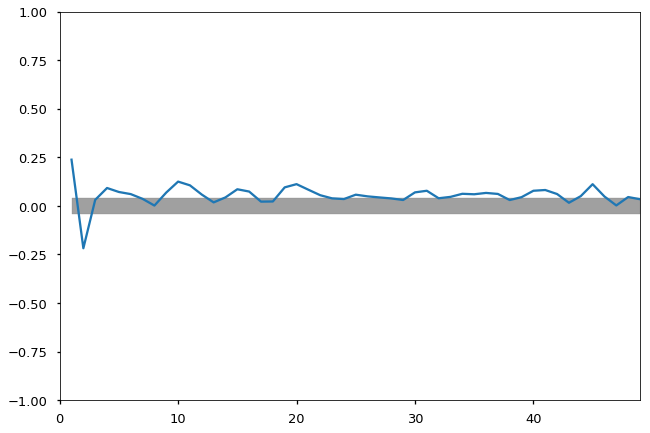

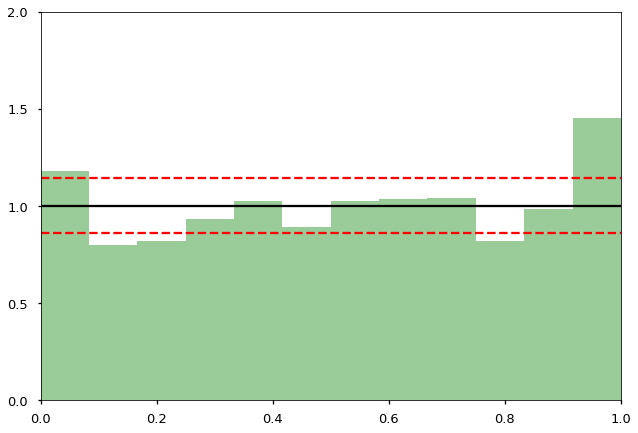

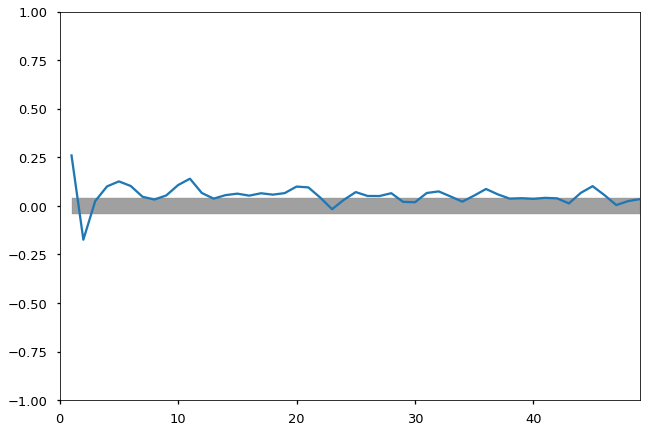

In [32]:
for idx, val in enumerate(regressand.columns):
    estimates = pd.DataFrame(forecast[:,idx,:], index=data.index[2:])
    pit = cdpm.probability_integral_transform(estimates, data[val].iloc[2:])
    pit_fig, pit_ax = mpl.pyplot.subplots()
    cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
#     pit_ax.set_xlabel(val)
    pit_fig.savefig(f'../doc/density_figures/{val}_pit.tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=True,
                    frameon=False)
    
    acf_fig, acf_ax = mpl.pyplot.subplots()
#     acf_ax.set_xlabel(val)
    cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
    acf_fig.savefig(f'../doc/density_figures/{val}_pit_acf.tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=True,
                   frameon=False)